# **第7章 商品推薦のための興味のスコアリング**

### **7.3 データ分析**

### ②データの概要

In [1]:
import pandas as pd

# access_log.csvより閲覧履歴を取り込む
log_df = pd.read_csv('access_log.csv', parse_dates=['date'])
print(len(log_df))
log_df.head()

325908


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04


In [2]:
# ユーザーID(user_id)の統計値を確認する
log_df['user_id'].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: user_id, dtype: float64

In [3]:
# 商品ID(item_id)の統計値を確認する
log_df['item_id'].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: item_id, dtype: float64

In [4]:
# 閲覧日(date)の件数を確認する
log_df['date'].value_counts()

2015-07-03    45441
2015-07-02    45394
2015-07-01    44163
2015-07-04    43804
2015-07-08    39933
2015-07-05    39932
2015-07-07    33930
2015-07-06    33311
Name: date, dtype: int64

### **③ データの性質**

In [5]:
# 日付操作をするライブラリdatetimeを取り込む
import datetime

start_date = datetime.datetime(2015,7,1)
end_date = datetime.datetime(2015,7,7)
target_date = datetime.datetime(2015,7,8)
print(start_date, end_date, target_date) # 追記

2015-07-01 00:00:00 2015-07-07 00:00:00 2015-07-08 00:00:00


In [6]:
# 7月1日〜7月7日までのデータを抽出する（基準日7月8日は入っていない）
x_df = log_df[(start_date <= log_df['date']) & (log_df['date'] <= end_date)]
print(len(x_df))
x_df.head(3)

285975


,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04


In [7]:
# 基準日7月8日のデータを抽出する
y_df = log_df[log_df['date'] == target_date]
print(len(y_df))
y_df.head()

39933


,user_id,item_id,date
103,94,603852,2015-07-08
104,94,28600,2015-07-08
105,94,987320,2015-07-08
106,94,109924,2015-07-08
107,94,886214,2015-07-08


In [8]:
# ユーザーIDと閲覧した商品IDに対して、最新度のリストを対応させる辞書を作成する（ただし、辞書の入れ子として作成）
U2I2Rcens = {}
for row in x_df.itertuples():
    # 最新度(経過日数)の算出：基準日 - 最新の閲覧日
    rcen = (target_date - row.date).days
    
    # 辞書に最新度を登録
    U2I2Rcens.setdefault(row.user_id, {})
    U2I2Rcens[row.user_id].setdefault(row.item_id, [])
    U2I2Rcens[row.user_id][row.item_id].append(rcen)

In [9]:
# ユーザーID=2497について、閲覧した商品に対する最新度のリストを確認する
U2I2Rcens[2497]

{400521: [4, 2, 2, 2, 1], 678277: [4], 687963: [2], 178138: [1]}

In [10]:
# ユーザーIDと商品IDに対応する最新度(rcen)と頻度(freq)のデータを作成する
Rows1 = []
for user_id, I2Rcens in U2I2Rcens.items():
    for item_id, Rcens in I2Rcens.items():
        freq = len(Rcens)
        rcen = min(Rcens)
        Rows1.append((user_id, item_id, rcen, freq))
UI2RF_df = pd.DataFrame(Rows1, columns=['user_id', 'item_id', 'rcen', 'freq'])
print(len(UI2RF_df))
UI2RF_df.head()

204661


,user_id,item_id,rcen,freq
0,4,205587,4,1
1,4,748683,4,1
2,4,790055,4,3
3,4,764638,4,2
4,4,492434,4,1


In [11]:
# 閲覧フラグ(pv_flag)の作成
y_df = y_df.drop_duplicates()
print(len(y_df))
y_df['pv_flag'] = 1
y_df.head()

29651


,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1


In [12]:
# 閲覧フラグ(pv_flag)の追加
UI2RFP_df = pd.merge(UI2RF_df, y_df[['user_id', 'item_id', 'pv_flag']], how='left', on=['user_id', 'item_id'])
UI2RFP_df['pv_flag'].fillna(0, inplace=True)
print(len(UI2RFP_df))
UI2RFP_df.head()

204661


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [13]:
# 最新度(rcen)と頻度(freq)の取りうる範囲を確認
print(sorted(UI2RFP_df['rcen'].unique()))
print(sorted(UI2RFP_df['freq'].unique()))

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 41, 43, 58, 63, 118]


In [14]:
# 頻度(freq)が7以下になるようにデータを抽出(本書の都合でrcenと規模感を合わせるため)
tar_df = UI2RFP_df[UI2RFP_df['freq'] <= 7]
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [15]:
# 閲覧フラグ(pv_flag)の規模感の確認
tar_df['pv_flag'].sum()

2038.0

In [16]:
# 最新度(recency)に関する閲覧数の集計
rcen_df = pd.crosstab(index=tar_df['rcen'], columns=tar_df['pv_flag'])
rcen_df = rcen_df.rename(columns = {0:'neg', 1:'pos'})
rcen_df

pv_flag,neg,pos
rcen,,
1,24595,571
2,24032,274
3,28212,326
4,30641,275
5,31510,225
6,31721,199
7,30707,168


pv_flag,neg,pos,N,prob
rcen,,,,
1,24595,571,25166,0.022689
2,24032,274,24306,0.011273
3,28212,326,28538,0.011423
4,30641,275,30916,0.008895
5,31510,225,31735,0.007090
6,31721,199,31920,0.006234
7,30707,168,30875,0.005441


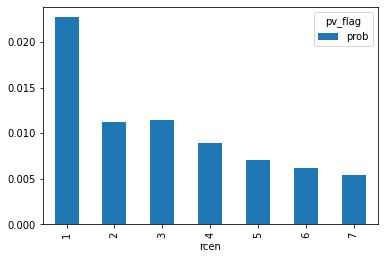

In [17]:
# 最新度(recency)に関する再閲覧確率の算出と確認
rcen_df['N'] = rcen_df['neg'] + rcen_df['pos']
rcen_df['prob'] = rcen_df['pos'] / rcen_df['N']
rcen_df[['prob']].plot.bar()
rcen_df

In [18]:
# 頻度(frequency)に関する閲覧数の集計
freq_df = pd.crosstab(index=tar_df['freq'], columns=tar_df['pv_flag'])
freq_df = freq_df.rename(columns = {0:'neg', 1:'pos'})
freq_df

pv_flag,neg,pos
freq,,
1,161753,964
2,24938,476
3,7733,258
4,3527,149
5,1807,88
6,1038,63
7,622,40


pv_flag,neg,pos,N,prob
freq,,,,
1,161753,964,162717,0.005924
2,24938,476,25414,0.018730
3,7733,258,7991,0.032286
4,3527,149,3676,0.040533
5,1807,88,1895,0.046438
6,1038,63,1101,0.057221
7,622,40,662,0.060423


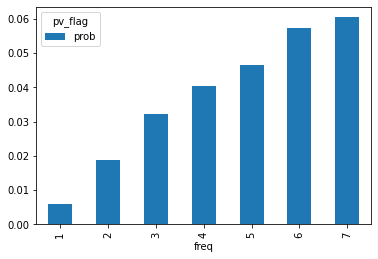

In [19]:
# 頻度(frequency)に関する再閲覧確率の算出と確認
freq_df['N'] = freq_df['neg'] + freq_df['pos']
freq_df['prob'] = freq_df['pos'] / freq_df['N']
freq_df[['prob']].plot.bar()
freq_df

### **7.4 数理モデリングと実装**

### ①数理モデル

In [20]:
# tar_dfの(再)確認
print(len(tar_df))
tar_df.head()

203456


,user_id,item_id,rcen,freq,pv_flag
0,4,205587,4,1,0.0
1,4,748683,4,1,0.0
2,4,790055,4,3,0.0
3,4,764638,4,2,0.0
4,4,492434,4,1,0.0


In [21]:
# 最新度(rcen)と頻度(freq)に対する総件数と再閲覧件数の算出
RF2N = {}
RF2PV = {}
for row in tar_df.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen, row.freq] += 1

In [22]:
# 最新度(rcen)と頻度(freq)に対する再閲覧確率の算出
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

In [23]:
# 最新度(rcen)と頻度(freq)に対して総件数、再閲覧件数、再閲覧確率を対応付けるデータの作成
Rows3 = []
for rf, N in sorted(RF2N.items()):
    pv = RF2PV[rf]
    prob = RF2Prob[rf]
    row = (rf[0], rf[1], N, pv, prob)
    Rows3.append(row)
rf_df = pd.DataFrame(Rows3, columns = ['rcen', 'freq', 'N', 'pv', 'prob'])
print(len(rf_df))
rf_df.head()

49


,rcen,freq,N,pv,prob
0,1,1,19602,245,0.012499
1,1,2,3323,132,0.039723
2,1,3,1120,81,0.072321
3,1,4,539,36,0.066790
4,1,5,285,36,0.126316


In [24]:
# 横持ち（テーブル形式）で確認
rf_df.pivot_table(index='rcen', columns='freq', values='prob')

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.072321,0.066790,0.126316,0.112994,0.175000
2,0.005856,0.021189,0.026973,0.056645,0.066225,0.098765,0.063830
3,0.006107,0.023230,0.039621,0.053265,0.039427,0.054054,0.050420
4,0.005454,0.015366,0.024521,0.046901,0.036667,0.037838,0.018349
5,0.004376,0.015504,0.023673,0.014925,0.021898,0.028902,0.030612
6,0.004456,0.009848,0.024514,0.019569,0.008511,0.024793,0.025316
7,0.004256,0.009086,0.014056,0.023377,0.009091,0.020408,0.000000


In [25]:
# データの可視化に必要なライブラリ群を取り込む
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

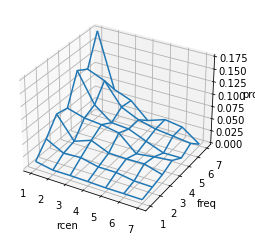

In [26]:
# 最新度(rcen)と頻度(freq)に対して再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df['freq'].unique().tolist()
Rcen = rf_df['rcen'].unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['prob'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='prob'
                    )
ax.plot_wireframe(X, Y, Z)

### **②数理最適化モデル** 

In [27]:
import cvxpy as cp     

(1)`rcen`と`freq`に対して再閲覧確率`pred_prob`を推定する

In [28]:
# 最新度(rcen)のリストと頻度(freq)のリストの作成
R = sorted(tar_df['rcen'].unique().tolist())
F = sorted(tar_df['freq'].unique().tolist())
print(R)
print(F)

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]


(2)`pred_prob`は`rcen`について単調減少する

In [29]:
# cvxpyのr,fの2次元の変数の作成
x = cp.Variable((len(R), len(F)))

# 制約条件のリストの作成
constraints = []

# - pred_prob[r,f] + pred_prob[r+1,f] <= 0 のモデリング
for r in range(len(R)-1):
    for f in range(len(F)):
        constraints += [x[r][f] >= x[r+1][f]]

(3)`pred_prob`は`freq`について単調増加する

In [30]:
# pred_prob[r,f] - pred_prob[r,f+1] <= 0 のモデリング
for r in range(len(R)):
    for f in range(len(F)-1):
        constraints += [x[r][f] <= x[r][f+1]]

(4)`pred_prob`と`prob`の二乗誤差を総件数の重み付きで最小化する

In [31]:
# N[r,f] * (pred_prob[r,f] - prob[r,f])^2 のモデリング
objectives = []
for r in range(len(R)):
    for f in range(len(F)):
        # 0-indexedのため、r,fに+1をする
        N = RF2N[r+1,f+1]
        prob = RF2Prob[r+1,f+1]
        objectives += [N * (x[r][f] - prob)**2]

In [32]:
# 求解
prob = cp.Problem(cp.Minimize(cp.sum(objectives)), constraints)
prob.solve()

0.4437506487908506

In [33]:
# 最新度(rcen)と頻度(freq)に対応する推定した再閲覧確率の辞書を作成
RF2PredProb = {}
for r in range(len(R)):
    for f in range(len(F)):
        # 0-indexedのため、r,fに+1をする
        RF2PredProb[r+1,f+1] = x.value[r][f]
rf_df['pred_prob'] = rf_df.apply(lambda y:RF2PredProb[y['rcen'], y['freq']], axis=1)
rf_df.head()        

,rcen,freq,N,pv,prob,pred_prob
0,1,1,19602,245,0.012499,0.012499
1,1,2,3323,132,0.039723,0.039723
2,1,3,1120,81,0.072321,0.070524
3,1,4,539,36,0.066790,0.070524
4,1,5,285,36,0.126316,0.121212


### **7.5 数理モデルの検証**

### ①数理モデルの確認

In [34]:
# 横持ちのデータに変更
rf_df.pivot_table(index='rcen', columns='freq', values='pred_prob')

freq,1,2,3,4,5,6,7
rcen,,,,,,,
1,0.012499,0.039723,0.070524,0.070524,0.121212,0.121212,0.175000
2,0.005992,0.022278,0.033765,0.056645,0.066225,0.085938,0.085937
3,0.005992,0.022278,0.033765,0.048780,0.048780,0.052632,0.052632
4,0.005454,0.015434,0.024521,0.040302,0.040302,0.040302,0.040302
5,0.004417,0.015434,0.021027,0.021027,0.021898,0.028902,0.030612
6,0.004417,0.009848,0.021027,0.021027,0.021027,0.024793,0.025316
7,0.004256,0.009086,0.014056,0.017426,0.017426,0.017426,0.017426


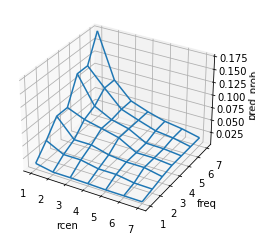

In [35]:
# 最新度(rcen)と頻度(freq)に対して推定した再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df.freq.unique().tolist()
Rcen = rf_df.rcen.unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['pred_prob'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='pred_prob'
                    )
ax.plot_wireframe(X, Y, Z)

### **②数理モデルの適用**

In [36]:
# はじめに紹介したデータを作成
Rows4 = [('item1', 1, 6)
        , ('item2', 2, 2)
        , ('item3', 1, 2)
        , ('item4', 1, 1)
        ]
sample_df = pd.DataFrame(Rows4, columns=['item_name', 'rcen', 'freq'])
sample_df

,item_name,rcen,freq
0,item1,1,6
1,item2,2,2
2,item3,1,2
3,item4,1,1


In [37]:
# 推定した再閲覧確率を結合
pd.merge(sample_df, rf_df, left_on=['rcen', 'freq'], right_on=['rcen', 'freq'])

,item_name,rcen,freq,N,pv,prob,pred_prob
0,item1,1,6,177,20,0.112994,0.121212
1,item2,2,2,3162,67,0.021189,0.022278
2,item3,1,2,3323,132,0.039723,0.039723
3,item4,1,1,19602,245,0.012499,0.012499


### **③数理モデルのブラッシュアップ**

rcen
1         NaN
2   -0.011416
3    0.000150
4   -0.002528
5   -0.001805
6   -0.000856
7   -0.000793
Name: prob, dtype: float64

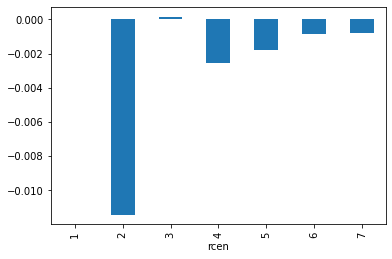

In [38]:
# 最新度(rcen)に対して、再閲覧確率の下降幅が小さくなることを確認
rcen_df['prob'].diff().plot.bar()
rcen_df['prob'].diff()

freq
1         NaN
2    0.012805
3    0.013556
4    0.008247
5    0.005905
6    0.010783
7    0.003202
Name: prob, dtype: float64

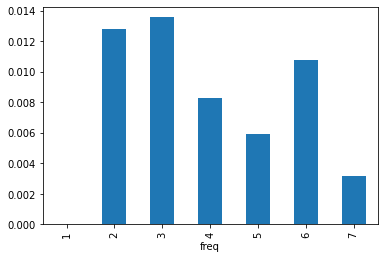

In [39]:
# 頻度(freq)に対して、再閲覧確率の上昇幅が小さくなることを確認
freq_df['prob'].diff().plot.bar()
freq_df['prob'].diff()

In [40]:
# - pred_prob[r,f] + 2 * pred_prob[r+1,f] - pred_prob[r+2,f] <= 0 のモデリング
for r in range(len(R)-2):
    for f in range(len(F)):
        constraints += [x[r][f] - x[r+1][f] >= x[r+1][f] - x[r+2][f]]
        
# pred_prob[r,f] - 2 * pred_prob[r,f+1] + pred_prob[r,f+2] <= 0 のモデリング
for r in range(len(R)):
    for f in range(len(F)-2):
        constraints += [x[r][f] - x[r][f+1] >= x[r][f+1] - x[r][f+2]]       

### 全体のコード

In [41]:
# cvxpyのr,fの2次元の変数の作成
x = cp.Variable((len(R), len(F)))

# 制約条件のリストの作成
constraints = []

# - pred_prob[r,f] + pred_prob[r+1,f] <= 0 のモデリング
for r in range(len(R)-1):
    for f in range(len(F)):
        constraints += [x[r][f] >= x[r+1][f]]

# pred_prob[r,f] - pred_prob[r,f+1] <= 0 のモデリング
for r in range(len(R)):
    for f in range(len(F)-1):
        constraints += [x[r][f] <= x[r][f+1]]
        
# - pred_prob[r,f] + 2 * pred_prob[r+1,f] - pred_prob[r+2,f] <= 0 のモデリング
for r in range(len(R)-2):
    for f in range(len(F)):
        constraints += [x[r][f] - x[r+1][f] >= x[r+1][f] - x[r+2][f]]
        
# pred_prob[r,f] - 2 * pred_prob[r,f+1] + pred_prob[r,f+2] <= 0 のモデリング
for r in range(len(R)):
    for f in range(len(F)-2):
        constraints += [x[r][f] - x[r][f+1] >= x[r][f+1] - x[r][f+2]]       

# N[r,f] * (pred_prob[r,f] - prob[r,f])^2 のモデリング
objectives = []
for r in range(len(R)):
    for f in range(len(F)):
        # 0-indexedのため、r,fに+1をする
        N = RF2N[r+1,f+1]
        prob = RF2Prob[r+1,f+1]
        objectives += [N * (x[r][f] - prob)**2]

# 求解
prob = cp.Problem(cp.Minimize(cp.sum(objectives)), constraints)
prob.solve()

2.051259379508574

In [42]:
# 最新度(rcen)と頻度(freq)に対応する推定した再閲覧確率の辞書を作成
RF2PredProb2 = {}
for r in range(len(R)):
    for f in range(len(F)):
        # 0-indexedのため、r,fに+1をする
        RF2PredProb2[r+1,f+1] = x.value[r][f]
rf_df['pred_prob2'] = rf_df.apply(lambda y:RF2PredProb2[y['rcen'], y['freq']], axis=1)
rf_df.head()        

,rcen,freq,N,pv,prob,pred_prob,pred_prob2
0,1,1,19602,245,0.012499,0.012499,0.013024
1,1,2,3323,132,0.039723,0.039723,0.037337
2,1,3,1120,81,0.072321,0.070524,0.061650
3,1,4,539,36,0.066790,0.070524,0.085964
4,1,5,285,36,0.126316,0.121212,0.110277


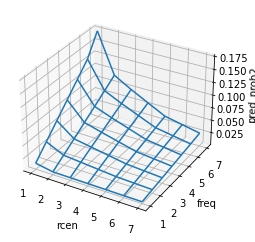

In [43]:
# 最新度(rcen)と頻度(freq)に対して推定した再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df['freq'].unique().tolist()
Rcen = rf_df['rcen'].unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['pred_prob2'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='pred_prob2'
                    )
ax.plot_wireframe(X, Y, Z)

### **7.7 凸二次計画問題の行列表現の補足（行列表現を利用しない）**

In [44]:
x = cp.Variable(3)

constraints = []

constraints += [0 <= x, x <= 1]

for i in range(2):
  constraints += [x[i] <= x[i+1]]

for i in range(1):
  constraints += [x[i+1] - x[i] >= x[i+2] - x[i+1]]

w = [100, 50, 10]
p = [0.1, 0.15, 0.25]

objective = cp.sum([w[i]*(x[i] - p[i])**2 for i in range(3)])

prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve()
x.value

array([0.09736842, 0.16052632, 0.22368421])